## Reproductible forecasting

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import jmstate
from jmstate import MultiStateJointModel
from jmstate.typedefs import *
from uniformbands import get_bands

In [2]:
torch.manual_seed(0)
sigmoid = torch.jit.script(jmstate.functions.sigmoid)

@torch.jit.script
def f(gamma, x, b):
    psi = gamma + b
    psi[..., 1].exp_()
    return psi

In [3]:
lmda, k = 6, 2
gamma = torch.tensor([4.0, 0.5, 6.0])
Q = torch.diag(torch.tensor([1.0, 0.1, 1.0]))
Q_dist = torch.distributions.MultivariateNormal(torch.zeros(3), Q)
R = torch.tensor([[1.1]])
R_dist = torch.distributions.MultivariateNormal(torch.zeros(1), R)

alphas = {(0, 1): torch.tensor([.4])}
betas = {(0, 1): torch.tensor([-0.9, 0.8, .2])}

real_params = ModelParams(
    gamma,
    (jmstate.utils.flat_from_cov(Q, method="diag"), "diag"),
    (jmstate.utils.flat_from_cov(R, method="ball"), "ball"),
    alphas,
    betas
)

In [4]:
weibull_fn = jmstate.functions.weibull(k, lmda)
surv = {(0, 1): (weibull_fn, sigmoid)}
model_design = ModelDesign(f, sigmoid, surv)
real_model = MultiStateJointModel(model_design, real_params)

n, p = 500, 3
t = torch.linspace(0, 15, 15)
c = torch.rand(n, 1) * 5 + 10
x = torch.randn(n, p)

b = Q_dist.sample((n,))
psi = f(gamma, x, b)

trajectories_init = [[(0.0, 0)] for _ in range(n)]
sample_data = SampleData(x, trajectories_init, psi)
trajectories = real_model.sample_trajectories(sample_data, c.view(-1, 1))

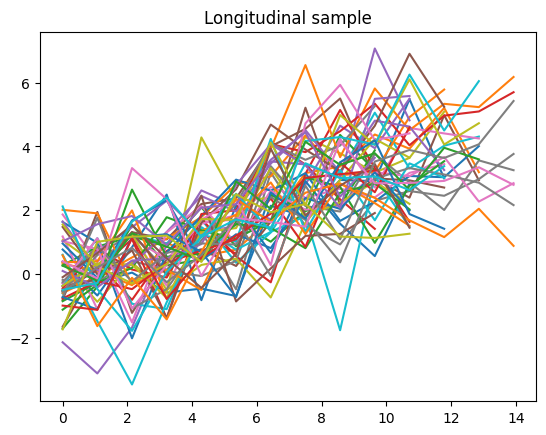

In [5]:
y = model_design.regression_fn(t, psi).squeeze(0)
y += R_dist.sample(y.shape[:2])
y[t.repeat(n, 1) > c.view(-1, 1)] = torch.nan

plt.plot(t, y[:50].squeeze(-1).T)
plt.title("Longitudinal sample")
plt.show()

Running joint model: 100%|██████████| 200/200 [00:03<00:00, 54.90it/s]


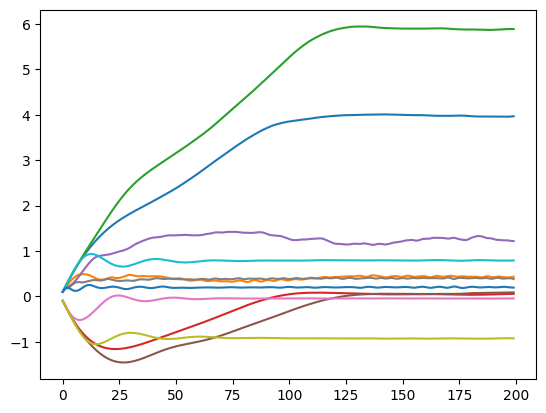

In [6]:
init_params = ModelParams(
    torch.zeros_like(gamma),
    (torch.zeros_like(jmstate.utils.flat_from_cov(Q, method="diag")), "diag"),
    (torch.zeros_like(jmstate.utils.flat_from_cov(R, method="ball")), "ball"),
    {k: torch.zeros_like(v) for k, v in alphas.items()},
    {k: torch.zeros_like(v) for k, v in betas.items()},
)

model = MultiStateJointModel(model_design, init_params)

data = ModelData(
    x, t, y, trajectories, c
)

metrics = model.do(data, jobs=[jmstate.jobs.Fit(), jmstate.jobs.LogParamsHistory()])

plt.plot(torch.cat([p.as_flat_tensor[None] for p in metrics], dim=0))
plt.show()

In [7]:
metrics = model.do(data, jobs=jmstate.jobs.ComputeFIM())

Running joint model:  25%|██▌       | 50/200 [00:02<00:08, 16.88it/s]


KeyboardInterrupt: 

In [ ]:
n_test = 100
x_test = torch.randn(n_test, p)
b_test = Q_dist.sample((n_test,))
psi_test = f(gamma, None, b_test)
trajectories_init_test = [[(0.0, 0)] for _ in range(n_test)]
y_test = model_design.regression_fn(t, psi_test).squeeze(0)
y_test += R_dist.sample(y_test.shape[:-1])

In [ ]:
u_grid = torch.linspace(0, 8, 32)
c_test = torch.full((n_test,), 3.0).view(-1, 1)
c_max = torch.full((n_test,), 15.0).view(-1, 1)
pred_test_data = ModelData(
        x_test, t[t <= 3.0], y_test[:, t <= 3.0, :],
        trajectories_init_test, c_test
    )
other = model.do(pred_test_data, jobs=[jmstate.jobs.PredictTrajectories(c_max)], n_chains=10, n_iterations=100)

Running joint model:  20%|██        | 20/100 [00:01<00:06, 12.37it/s]


KeyboardInterrupt: 

Running joint model: 100%|██████████| 200/200 [00:01<00:00, 101.96it/s]


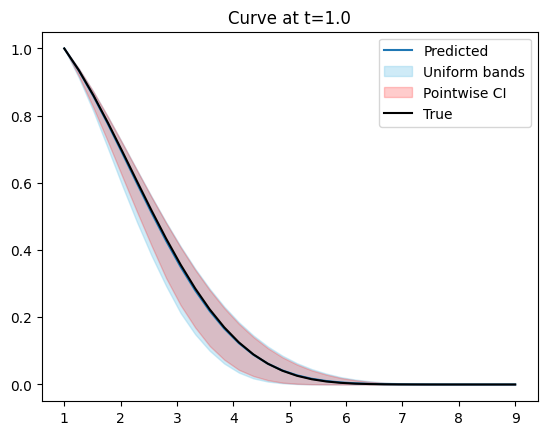

Time 1.0: Uniform coverage = 0.940, Pointwise coverage = 0.880


Running joint model: 100%|██████████| 200/200 [00:04<00:00, 41.90it/s] 


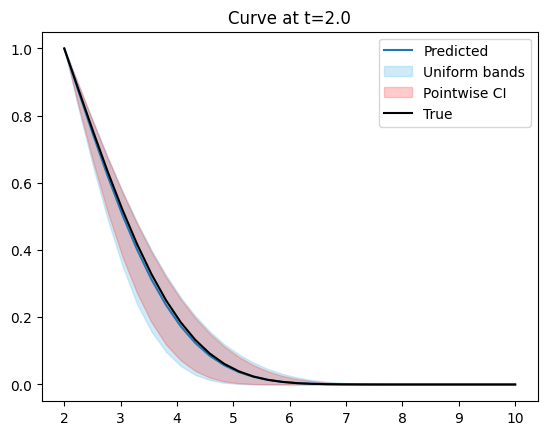

Time 2.0: Uniform coverage = 0.950, Pointwise coverage = 0.890


Running joint model: 100%|██████████| 200/200 [00:03<00:00, 56.30it/s]


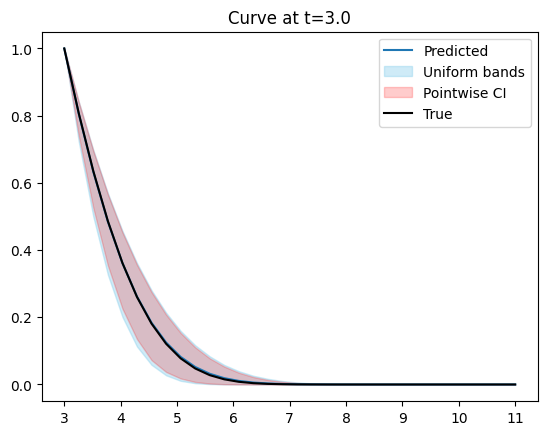

Time 3.0: Uniform coverage = 0.940, Pointwise coverage = 0.870


Running joint model: 100%|██████████| 200/200 [00:02<00:00, 70.14it/s]


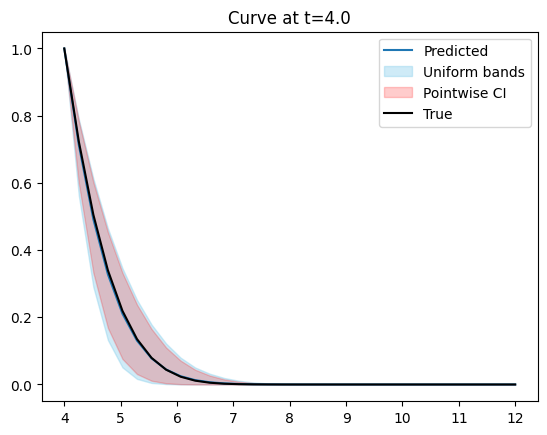

Time 4.0: Uniform coverage = 0.940, Pointwise coverage = 0.910

Overall coverage:
Uniform bands: 0.943
Pointwise CI: 0.888


In [ ]:
prediction_times = torch.linspace(1.0, 4.0, 4)
u_grid = torch.linspace(0, 8, 32)

logps_true = []
for time in prediction_times:
    c_test = torch.full((n_test,), time).view(-1, 1)
    sample_test_data = SampleData(x_test, trajectories_init_test, psi_test, c_test)
    u = c_test.view(-1, 1) + u_grid.view(1, -1)
    logps_true.append(real_model.compute_surv_logps(sample_test_data, u))

uniform_coverage = []
pointwise_coverage = []

for i, time in enumerate(prediction_times):
    c_test = torch.full((n_test,), time).view(-1, 1)

    pred_test_data = ModelData(
        x_test, t[t <= time], y_test[:, t <= time, :],
        trajectories_init_test, c_test
    )

    u = c_test.view(-1, 1) + u_grid.view(1, -1)
    logps_pred = real_model.do(pred_test_data, jobs=[jmstate.jobs.PredictSurvLogps(u)])
    logps_pred = torch.cat([d.unsqueeze(0) for d in logps_pred], dim=0)
    logps_pred = logps_pred.permute((1, 0, 2))

    uniform_covered_count = 0
    pointwise_covered_count = 0

    true_prob = torch.exp(logps_true[i]).numpy()
    pred_probs = torch.exp(logps_pred).numpy()

    bands = get_bands(pred_probs)
    pointwise = np.quantile(pred_probs, [0.025, 0.975], axis=1)

    uniform_covered_count += np.all((true_prob >= bands["lower"]) & (true_prob <= bands["upper"]), axis=1).mean()
    pointwise_covered_count += np.all((true_prob >= pointwise[0]) & (true_prob <= pointwise[1]), axis=1).mean()

    points = time + u_grid
    plt.plot(points, pred_probs[0].mean(axis=0), label="Predicted")
    plt.fill_between(points, bands["lower"][0], bands["upper"][0], color="skyblue", alpha=0.4, label="Uniform bands")
    plt.fill_between(points, pointwise[0, 0], pointwise[1, 0], color="red", alpha=0.2, label="Pointwise CI")
    plt.plot(points, true_prob[0], label="True", color="black")
    plt.title(f"Curve at t={time:.1f}")
    plt.legend()
    plt.show()

    uniform_coverage.append(uniform_covered_count)
    pointwise_coverage.append(pointwise_covered_count)

    print(f"Time {time:.1f}: Uniform coverage = {uniform_coverage[-1]:.3f}, Pointwise coverage = {pointwise_coverage[-1]:.3f}")

print("\nOverall coverage:")
print(f"Uniform bands: {np.mean(uniform_coverage):.3f}")
print(f"Pointwise CI: {np.mean(pointwise_coverage):.3f}")

Running joint model: 100%|██████████| 200/200 [00:00<00:00, 276.06it/s]


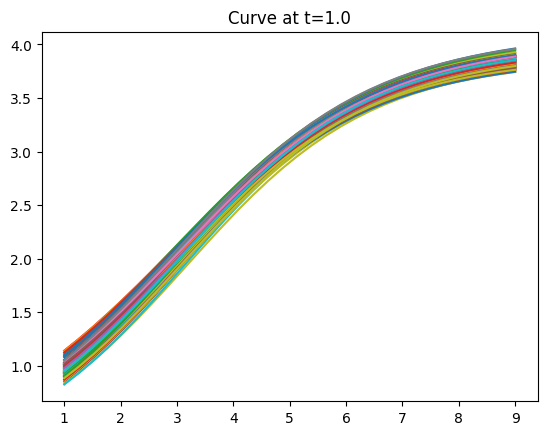

Running joint model: 100%|██████████| 200/200 [00:01<00:00, 113.74it/s]


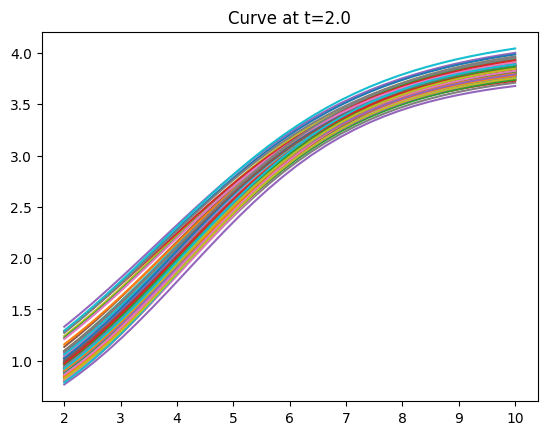

Running joint model: 100%|██████████| 200/200 [00:01<00:00, 157.58it/s]


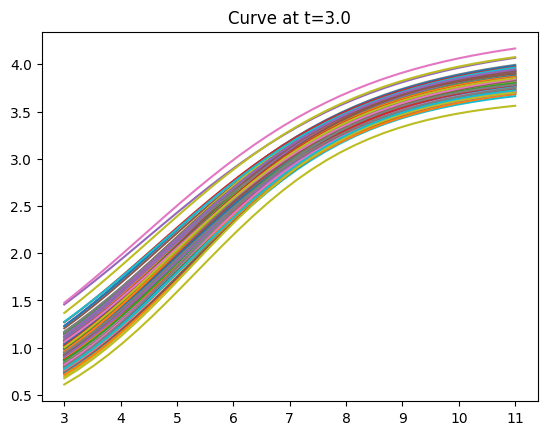

Running joint model: 100%|██████████| 200/200 [00:01<00:00, 166.21it/s]


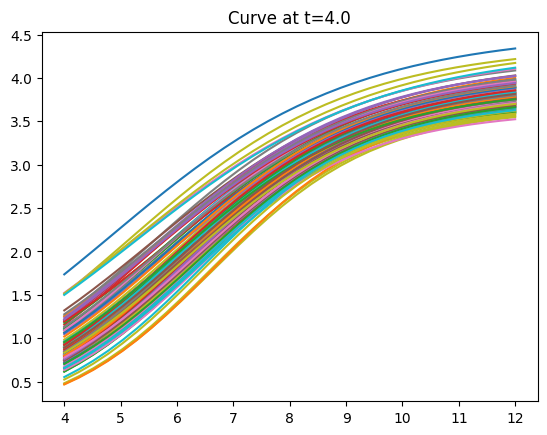

In [ ]:
for i, time in enumerate(prediction_times):
    c_test = torch.full((n_test,), time).view(-1, 1)

    pred_test_data = ModelData(
        x_test, t[t <= time], y_test[:, t <= time, :],
        trajectories_init_test, c_test
    )
    y_pr = torch.cat(real_model.do(pred_test_data, jobs=jmstate.jobs.PredictY(u)), dim=2)
    points = time + u_grid
    plt.plot(points, y_pr.mean(dim=2).T)
    plt.title(f"Curve at t={time:.1f}")
    plt.show()

In [ ]:
other = model.do(data, jobs=[jmstate.jobs.ComputeEBEs(), jmstate.jobs.ComputeCriteria()])
print(other)

Running joint model: 100%|██████████| 200/200 [00:03<00:00, 58.16it/s]

Metrics(loglik=-9840.676496093754, ebes=tensor([[-0.0770, -0.1784,  1.0275],
        [ 0.2553, -0.0713,  0.3853],
        [-0.3695,  0.0221,  0.5420],
        ...,
        [ 0.2826,  0.2670, -0.9145],
        [ 0.5427, -0.1084,  0.1344],
        [ 0.8493, -0.1344, -0.4525]]), nloglik_pen=9840.676496093754, aic=19703.35299218751, bic=19749.71368230439)
